
<font face="Calibri">
<br>
<font size="6", color='rgba(200,0,0,0.2)'> <b>Flood Mapping from Single Sentinel-1 SAR Images</b>
</font>
<br>
<font size="3"> <b> Franz J Meyer, University of Alaska Fairbanks</b> <br>
</font>
<font size="4"> <b> Adapted and consolidated for MPC by André de Oliveira</b> <br>
</font>

<font size="3">
    
This notebook is a consolidated version of the Open SAR Lab <cite><a href="https://mybinder.org/v2/gh/ASFBinderRecipes/Binder_SAR_Hazards_Floods/main?labpath=SARHazards_Lab_Floods.ipynb"><i>SARHazards_Lab_Floods</i></a></cite> notebook from the <cite><a href="https://mybinder.org/v2/gh/ASFBinderRecipes/Binder_SAR_Hazards_Floods/main?labpath=SARHazards_Lab_Floods.ipynb"><i>ARSET - SAR for Detecting and Monitoring Floods, Sea Ice, and Subsidence from Groundwater Extraction</i></a></cite>. It has been adapted to run inside of Microsoft Planetary Computer (MPC) instead of Binder. It can be run outside of MPC.
See <cite><a href="https://github.com/andreldeod/opensarlab-notebooks/tree/474bc4c513bea4959cb9c24eca8988658e83a730"><i>ASF repo</i></a></cite> for more resources for ASF workshops.


To run this notebook you must also have the following modules in your notebook directory:
1. asf_notebook_FloodMapping.py (Module downloaded from Binder. Included in repo)
2. SARHazards_Lab_Floods_functions.py (Contains all the functions from the original notebook. Included in repo.)
3. SAR_flooding_env.yml environment file (Binder environment, downloaded from Binder notebook. Included in repo.)
4. You will need a Height Above Nearest Drainage (HAND) file calculated from a DEM. You can make a HAND file with ASF's <cite><a href="https://github.com/andreldeod/opensarlab-notebooks/blob/474bc4c513bea4959cb9c24eca8988658e83a730/SAR_Training/English/HydroSAR/Big_Hand_notebook.ipynb"><i>Big_Hand_notebook.</i></a></cite> I have modified this notebook to run in MPC. See the repo for the modified version.
5. You will need a Sentinel 1 RTC VV and VH TIF files. The data_query notebook in the repo shows how to download RTC data from MPC's catalogues.
6. Finally you will need to set up the environment that the notebook uses in Binder. Here are the steps for that:
       a. Open a Terminal in the Jupyter notebook. 
       b. Open the SetupEnvironment notebook from the repo.
       c. Run each line of code from the SetupEnvironment notebook your terminal.
       d. Return to this notebook and change the Kernel using the Kernel tab at the top left:
           Kernel > Change Kernel > Python[conda env:asf-jupyter-notebook]


--------------Notes from original notebook:

<font size="3">This notebook presents a SAR-based flood mapping approach that largely follows a methodology developed by the German Aerospace Center and published in <cite><a href="https://www.tandfonline.com/doi/full/10.1080/01431161.2016.1192304"><i>Sentinel-1-based flood mapping: a fully automated processing chain</i></a> by Twele et al.</cite>. The approach is based on radiometricall terrain corrected (RTC processed) Sentinel-1 SAR data and applies a dynamic thresholding method followed by fuzzy-logic-based post processing procedure. This notebook implements the initial threshold-based flood mapping approach but, for simplicity, does not include the fuzzy-logic post processing steps. 

The approach is based on image amplitude data and is capable of detecting standing surface water. Note that flooding under vegetation will not be detected by this approach.
</font>

# General Methodology and Workflow

<font face="Calibri" size="3">The workflow of the Sentinel-1-based processing chain, as outlined in the figure below, is composed of the following main elements: 
<ol>
  <li><b>Find relevant SAR data</b> over your area of interest at the <a href="https://search.asf.alaska.edu/#/">Alaska Satellite Facility's SAR archive</a> and <b>Perform geometric and radiometric terrain correction</b> using the RTC processing flow by <a href="https://www.gamma-rs.ch/">GAMMA Remote Sensing</a>,</li>
  <li><b>adaptive and automatic threshold calculation</b> as discussed in the course,</li>
  <li><b>initial flood detection</b> by applying the calculated threshold image wide,</li>
  <li><b>fuzzy-logic-based classification refinement</b>,</li>
  <li><b>final classification into permanent and flood waters</b> using auxiliary data, and</li>
  <li><b>dissemination of the results</b>.</li>
</ol>

This notebook will focus on Steps 2 and 3.

<b><i>Step 1 </i></b> of this workflow are operationally implemented in the Alaska Satellite Facility's Hybrid Pluggable Processing Pipeline (HyP3) environment and accessible to the public at the <a href="https://hyp3.asf.alaska.edu/">HyP3 Website</a>. 
</font>
<img style="padding: 7px" src="https://courses.edx.org/asset-v1:AlaskaX+SAR-401+3T2020+type@asset+block@Watermappingworkflow2.jpg" width="70%"/>

# Flood Mapping Procedure

## Loading Python Libraries

In [1]:
## Import libraries
import glob
import os
from typing import Tuple

import numpy as np
from osgeo import gdal
import pyproj
import pandas as pd
#import rasterio
import skfuzzy
import ipywidgets as ui
# for add_subplot, axis, figure, imshow, legend, plot, set_axis_off, set_data,
# set_title, set_xlabel, set_ylabel, set_ylim, subplots, title, twinx
import matplotlib.pyplot as plt 

# Added for adated notebook
from datetime import datetime
import geopandas as gpd
import matplotlib.dates as mdates
from rasterio.plot import show
from rasterio.plot import plotting_extent
from rasterio.mask import mask
import shutil
import tempfile
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Import functions from original notebook
from SARHazards_Lab_Floods_functions import *

%matplotlib widget

## See imported module SARHazards_Lab_Floods_functions for the helper scripts from the original notebook. 

## Load SAR Data Sets to Process

<font face="Calibri" size="3"><b>Move into the parent directory of the directory containing the data and create a directory in which to store the water masks.</b></font>
<font face="Calibri" size="3"><b>Then create a dictionary of VV/VH pairs and check it for completeness</b></font>

In [6]:
## LOAD SAR DATA AND PAIR VV & VH IMAGES
name = "GuyanaFlooding/"
tiff_dir = path = f"/home/jovyan/{name}"


# analysis_directory = tiff_dir
rtc_directory = '/home/jovyan/GuyanaFlooding/data/rtc'
os.chdir(tiff_dir)
mask_directory = f'{tiff_dir}/data/Water_Masks'

if not os.path.exists(mask_directory):
    os.mkdir(mask_directory)
print(f"Current working directory: {os.getcwd()}")

paths = f"{rtc_directory}/*_v*.tif*"
if os.path.exists(tiff_dir):
    tiff_paths = get_tiff_paths(paths)

## Create a dictionary of VV/VH pairs and check it for completeness
grouped_pths = group_polarizations(tiff_paths)
if not confirm_dual_polarizations(grouped_pths):
    print("ERROR: AI_Water requires both VV and VH polarizations.")
else:
    print("Confirmed presence of VV and VH polarities for each product.")
    
#print(grouped_pths) #uncomment to print VV/VH path pairs

Current working directory: /home/jovyan/GuyanaFlooding
Confirmed presence of VV and VH polarities for each product.


The commented code if if you would like to only use a subset of the RTC files in the directory.

In [3]:
#### OPTIONAL: CHANGE WHAT GROUP PATHS IS TO NOT PROCESS ALL FILES ####

# # # Get the dictionary items as a list and slice it
# # # Assuming you want to start processing from the 11th to the 19th pair 
# # #(zero-indexed, adjust if one-indexed)
# # Example:
# # start_index = 10  # 11th item in zero-based index
# # end_index = 19    # 19th item in zero-based index (inclusive)
# start_index = 7
# end_index = 30


# # Get only the selected part of the dictionary
# grouped_pths = dict(list(grouped_pths.items())[start_index:end_index])

## Load HAND Layer for your AOI and Create HAND-Exclusion Mask (HAND-EM)

<font face="Calibri" size="3">This notebook uses a prepared Height Above Nearest Drainage (HAND) file that was cut to the same extent as the SAR image time series. A DEM is used to create HAND by calculating the height difference between a particular image pixels and the nearest drainage (such as the nearest river). 
    
To create the HAND Exclusion Mask (HAND-EM) we then threshold the HAND layer by assuming that pixels with a HAND value > 15 m are unlikely to be flooded. This means, in other words, we assume that flood waters are unlikely to exceed a depth of 15 m. 
</font>

In [7]:
#load HAND and derive HAND-EM
Hthresh = 15

HAND_file="/home/jovyan/GuyanaFlooding/data/hand_rupununi_32621.tif"
print(f"Selected HAND: {HAND_file}")
try:
    HAND_gT=gdal_get_geotransform(HAND_file)
except AttributeError:
    raise NoHANDLayerException(
        "Remember to select a HAND layer in the previous cell.")
HAND_proj4=get_proj4(HAND_file)
HAND=gdal_read(HAND_file)
hand = np.nan_to_num(HAND)

# Create Binary HAND-EM
Hmask = hand < Hthresh
handem = np.zeros_like(hand)
sel = np.ones_like(hand)
handem[Hmask] = sel[Hmask]

Selected HAND: /home/jovyan/GuyanaFlooding/data/hand_rupununi_32621.tif


<font face="Calibri" size="3"><b>Now let's plot HAND and HAND-EM side-by-side</b>. Dark blue regions in the HAND file (left) area areas near drainage systems such as rivers. These areas are most likely to be affected by floods. Areas in red, however, are at higher elevations and less likely to be flooded.

The HAND-EM layer to the right shows pixels unlikely to contain flood waters in black. These pixels are at least 15 m above the nearest drainage system.</font>

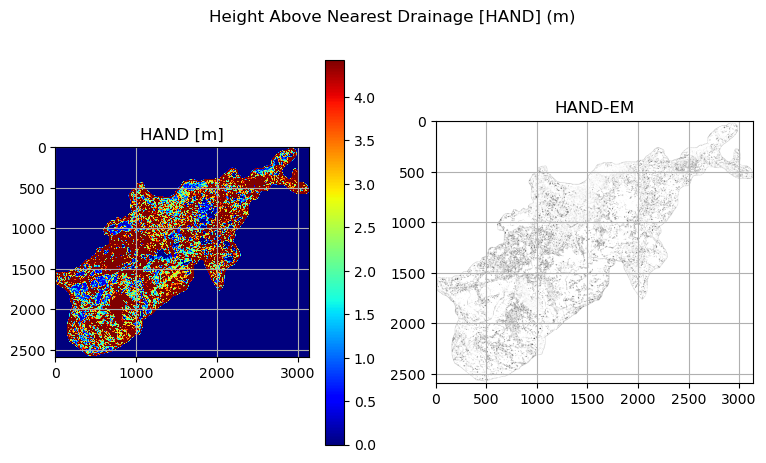

In [5]:
#### OPTIONAL: PLOT HAND AND HAND-EM LAYER ####
%matplotlib inline

fig = plt.figure(figsize=(9, 5))
plt.suptitle('Height Above Nearest Drainage [HAND] (m)')
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
vmin = np.percentile(hand, 5)
vmax = np.percentile(hand, 95)
hh = ax1.imshow(hand, cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_title('HAND [m]')
ax1.grid()
fig.colorbar(hh,ax=ax1)
ax2.imshow(handem, cmap='gray')
ax2.set_title('HAND-EM')
ax2.grid()

## Do Initial Flood Mapping using Adaptive Dynamic Thresholding

A bit of background on the implemented approach:

<font face="Calibri" size="3"><u><b>This is what is implemented in this notebook</b></u>: An automatic tile-based thresholding procedure (Martinis, Twele, and Voigt 2009) is used to generate an land/water classification. The selection of tiles is performed on a bilevel quadtree structure with parent level $L^+$ and child level $L^−$:
    
1. Firstly, the entire data are separated into quadratic non-overlapping parent tiles on level $L^+$ with a size of $100 \times 100$ pixels. Each parent object is further represented by four quadratic child objects on a second level $L^−$. The tile selection process is based on statistical hierarchical relations between parent and child objects. 
2. A number of parent tiles is automatically selected which offer the highest (>95% quantile) coefficient of variation on $L^+$ of the mean backscatter values of the respective child objects on $L^−$. This criterion serves as a measure of the degree of variation within the data and can therefore be used as an indicator of the probability that the tiles are characterized by spatial inhomogeneity and contain more than one semantic class. The selected parent objects should also have a mean individual backscatter value lower than the mean of all parent tiles on $L^+$. This ensures that tiles lying on the boundary between water and no water areas are selected. In case that no tiles fulfil these criteria, the tile size on $L^+$ and $L^−$ is halved and the quantile for the tile selection is reduced to 90% to guarantee a successful tile selection also in data with a relatively low extent of water surfaces or with smaller dispersed water bodies. 
3. To improve the robustness of the automatic threshold derivation the approach restricts the tile selection in Step (3) to only pixels situated in flood-prone regions defined by a Height Above Nearest Drainage (HAND)-based binary Exclustion Mask (HAND-EM). To create HAND-EM, a threshold is applied to HAND to identify non-flood prone areas. A threshold value of $\geq 15m$ is proposed. The HAND-EM further is shrunk by one pixel using an 8-neighbour function to account for potential geometric inaccuracies between the exclude layer and SAR data. Tiles are only considered in case less than 20% of its data pixels are excluded by HAND-EM.
4. Out of the number of the initially selected tiles, a limited number of N parent tiles are finally chosen for threshold computation. This selection is accomplished by ranking the parent tiles according to the standard deviation of the mean backscatter values of the respective child objects. Tiles with the highest values are chosen for $N$. Extensive testing yielded that $N = 5$ is a sufficient number of parent tiles for threshold computation. 
5. A multi-mode Expectation Maximization minimum error thresholding approach is then employed to derive local threshold values using a cost function which is based on the statistical parameterization of the sub-histograms of all selected tiles as bi-modal Gaussian mixture distributions. In order to derive a global (i.e. scenebased) threshold, the locally derived thresholds are combined by computing their arithmetic mean. 
6. Using the dynamically calculated threshold, both the VV and VH scenes are thresholded for water detection
7. The detected water maps are combined for arrive at an intial water mask that can be further refined in post processing <br><br> 

<u><b>Here some additional refinement steps that could be added to the notebook in the future</b></u>: 

1. <b>Calculation of attributes for fuzzy-logic post processing</b>: Based on the preliminary classification, the mean elevation of water objects and the size of all individual flood objects should be calculated. Together with the earlier derived land–water threshold, these parameters calculated from the initial classification can later be used to define fuzzy thresholds for the standard $S$ and $Z$ membership functions (see Section on Post Processing). This means that the initial classification based on the automatic thresholding procedure is mandatory to build elements for the fuzzy-logic-based refinement.</font>

<font face="Calibri" size="4"><b>RTC image prerequisits:</b></font>
<font face="Calibri" size="3"><b>
1. RTC tif files must have a No Data value of 0</b></font>
2. RTC files should be in the same CRS projection as the HAND file. For our example we used EPSG:32621.

This will be covered if you downloaded the RTC data from MPC using the data_query notebook from the repo.
If not, you can run the commented codes below.

In [21]:
#### OPTIONAL: CHECK IF NO DATA VALUES ARE 0

# # rtc_directory = "/home/jovyan/GuyanaFlooding/data/rtc/"

# for filename in sorted(os.listdir(rtc_directory)):
#     if filename.endswith("_vv.tif"):
#         rtc_file = os.path.join(rtc_directory, filename)
#         with rasterio.open(rtc_file) as src:
#             nodata = src.nodatavals[0]  # Assuming only one band
#             print(f"NoData value of {filename}: {nodata}")

NoData value of S1A_RTC_Guyana_2019_01_06_vv.tif: 0.0
NoData value of S1A_RTC_Guyana_2019_01_18_vv.tif: 0.0
NoData value of S1A_RTC_Guyana_2019_01_30_vv.tif: 0.0
NoData value of S1A_RTC_Guyana_2019_02_11_vv.tif: 0.0
NoData value of S1A_RTC_Guyana_2019_02_23_vv.tif: 0.0
NoData value of S1A_RTC_Guyana_2019_03_07_vv.tif: 0.0
NoData value of S1A_RTC_Guyana_2019_03_19_vv.tif: 0.0
NoData value of S1A_RTC_Guyana_2019_03_31_vv.tif: 0.0
NoData value of S1A_RTC_Guyana_2019_04_12_vv.tif: 0.0
NoData value of S1A_RTC_Guyana_2019_04_24_vv.tif: 0.0
NoData value of S1A_RTC_Guyana_2019_05_06_vv.tif: 0.0
NoData value of S1A_RTC_Guyana_2019_05_18_vv.tif: 0.0
NoData value of S1A_RTC_Guyana_2019_05_30_vv.tif: 0.0
NoData value of S1A_RTC_Guyana_2019_06_11_vv.tif: 0.0
NoData value of S1A_RTC_Guyana_2019_06_23_vv.tif: 0.0
NoData value of S1A_RTC_Guyana_2019_07_05_vv.tif: 0.0
NoData value of S1A_RTC_Guyana_2019_07_17_vv.tif: 0.0
NoData value of S1A_RTC_Guyana_2019_07_29_vv.tif: 0.0
NoData value of S1A_RTC_Guya

In [ ]:
#### OPTIONAL: CODE TO NO DATA VALUE TO 0


# #rtc_directory = "/home/jovyan/GuyanaFlooding/data/rtc/"

# for filename in os.listdir(rtc_directory):
#     if filename.endswith(".tif"):
#         file_path = os.path.join(rtc_directory, filename)
#         temp_file_path = None  # Initialize the variable outside of the try block

#         try:
#             # Open the existing TIFF file safely for reading
#             with rasterio.open(file_path) as src:
#                 data = src.read(1)  # read the first band into an array
#                 profile = src.profile
#                 original_nodata = profile['nodata']

#                 # Check if the original nodata value is not 0
#                 if original_nodata is not None and original_nodata != 0:
#                     # Create a temporary file to write modified data
#                     with tempfile.NamedTemporaryFile(delete=False, 
#                                                      suffix='.tif', 
#                                                      dir=rtc_directory) \
#                                                     as tmpfile:
#                         temp_file_path = tmpfile.name

#                     # Update the profile to specify the new NoData value and 
#                     #replace existing NoData values
#                     profile.update(nodata=0)
#                     mask = data == original_nodata
#                     if np.any(mask):
#                         data[mask] = 0
#                         print(f"NoData values replaced in {filename}")

#                     # Write the modified data to the temporary file
#                     with rasterio.open(temp_file_path, 'w', **profile) as dst:
#                         dst.write(data, 1)

#                     # Replace the original file with the updated one
#                     shutil.move(temp_file_path, file_path)
#                     print(f"Updated NoData value for {filename}")
#                 else:
#                     print(f"Skipping {filename}: "
#                           f"No changes needed as nodata value is already 0.")


#         except Exception as e:
#             print(f"Failed to process {filename}: {str(e)}")
#             # Remove the temporary file if it exists and an error occurs
#             if temp_file_path and os.path.exists(temp_file_path):
#                 os.remove(temp_file_path)


In [22]:
#### OPTIONAL: PRINT PROJECTIONS OF RTC FILES

# Iterate over each file in the rtc directory
for filename in os.listdir(rtc_directory):
    if filename.endswith(".tif"):  # Select only TIFF files
        file_path = os.path.join(rtc_directory, filename)
        try:
            # Open the file and print its CRS along with the filename
            with rasterio.open(file_path) as src:
                crs = src.crs
                print(f"File: {filename}, CRS: {crs}")
        except Exception as e:
            print(f"Failed to open {filename}: {e}")

File: S1A_RTC_Guyana_2019_06_23_vh.tif, CRS: EPSG:32621
File: S1A_RTC_Guyana_2019_07_29_vv.tif, CRS: EPSG:32621
File: S1A_RTC_Guyana_2019_11_26_vh.tif, CRS: EPSG:32621
File: S1A_RTC_Guyana_2019_02_11_vv.tif, CRS: EPSG:32621
File: S1A_RTC_Guyana_2019_11_14_vv.tif, CRS: EPSG:32621
File: S1A_RTC_Guyana_2019_03_19_vv.tif, CRS: EPSG:32621
File: S1A_RTC_Guyana_2019_01_06_vv.tif, CRS: EPSG:32621
File: S1A_RTC_Guyana_2019_07_17_vh.tif, CRS: EPSG:32621
File: S1A_RTC_Guyana_2019_07_05_vv.tif, CRS: EPSG:32621
File: S1A_RTC_Guyana_2019_01_30_vh.tif, CRS: EPSG:32621
File: S1A_RTC_Guyana_2019_10_09_vv.tif, CRS: EPSG:32621
File: S1A_RTC_Guyana_2019_05_30_vv.tif, CRS: EPSG:32621
File: S1A_RTC_Guyana_2019_11_26_vv.tif, CRS: EPSG:32621
File: S1A_RTC_Guyana_2019_08_10_vv.tif, CRS: EPSG:32621
File: S1A_RTC_Guyana_2019_12_20_vv.tif, CRS: EPSG:32621
File: S1A_RTC_Guyana_2019_12_20_vh.tif, CRS: EPSG:32621
File: S1A_RTC_Guyana_2019_09_15_vv.tif, CRS: EPSG:32621
File: S1A_RTC_Guyana_2019_07_05_vh.tif, CRS: EPS

In [ ]:
#### OPTIONAL: CHANGE ALL RTC FILES TO MATCH CRS OF HAND FILE

# #rtc_directory = "/home/jovyan/GuyanaFlooding/data/rtc/"

# # Open the HAND file to get its CRS
# with rasterio.open(HAND_file) as src_hand:
#     crs_hand = src_hand.crs
#     print(crs_hand)


# # List to store filenames whose CRS needs to be changed
# changed_files = []

# # Function to extract the desired part of the filename
# def extract_date_from_filename(filename):
#     parts = filename.split('_')
#     return '_'.join(parts[-3:]) 

# # Iterate over each file in the rtc directory
# for filename in sorted(os.listdir(rtc_directory)):
#     if filename.endswith(".tif"):  
#         rtc_file = os.path.join(rtc_directory, filename)
#         # Open the RTC file to check its CRS
#         with rasterio.open(rtc_file) as src_rtc:
#             crs_rtc = src_rtc.crs
#             print(extract_date_from_filename(filename), "Projection before change:", crs_rtc)
#             if crs_rtc != crs_hand:
#                 try:
#                     # Reproject the RTC file to match the CRS of the HAND file
#                     with rasterio.open(rtc_file) as src_rtc:
#                         transform, width, height = calculate_default_transform(
#                             src_rtc.crs, crs_hand, src_rtc.width, src_rtc.height, *src_rtc.bounds)
#                         kwargs = src_rtc.meta.copy()
#                         kwargs.update({
#                             'crs': crs_hand,
#                             'transform': transform,
#                             'width': width,
#                             'height': height
#                         })
#                         output_rtc_file = rtc_file.replace('.tif', '_reprojected.tif')
#                         with rasterio.open(output_rtc_file, 'w', **kwargs) as dst:
#                             reproject(
#                                 source=rasterio.band(src_rtc, 1),
#                                 destination=rasterio.band(dst, 1),
#                                 src_transform=src_rtc.transform,
#                                 src_crs=src_rtc.crs,
#                                 dst_transform=transform,
#                                 dst_crs=crs_hand,
#                                 resampling=Resampling.nearest)
#                         changed_files.append(extract_date_from_filename(filename))
#                         print(f"CRS changed for {filename}.")
#                 except Exception as e:
#                     print(f"Failed to change CRS for {filename}: {e}")

# # Print the list of files whose CRS was changed, sorted
# print("Files whose CRS was changed:", sorted(changed_files))

<font face="Calibri" size="5"> Download the RTC files. </font>
<font face="Calibri" size="3">This will take a while to run.

In [8]:
# DOWNLOAD TIFF FILES

# define some variables you might want to change
# Standard deviation percentile threshold for pivotal tile selection
precentile = 0.95 
 # Setting tile size to use in thresholding algorithm
tilesize = 100          
tilesize2 = 50
# Threshold for required fraction of valid HAND-EM pixels per tile
Hpick = 0.8    
# VV threshold to use if threshold calculation did not succeed
vv_corr = -17.0 
 # VH threshold to use if threshold calculation did not succeed
vh_corr = -24.0         

# Tile up HAND-EM data
handem_p = pad_image(handem, tilesize)
hand_tiles = tile_image(handem_p,width=tilesize,height=tilesize)
Hsum = np.sum(hand_tiles, axis=(1,2))
Hpercent = Hsum/(tilesize*tilesize)

# Now do adaptive threshold selection
vv_thresholds = np.array([])
vh_thresholds = np.array([])
floodarea = np.array([])
vh_thresholds_corr = np.array([])
vv_thresholds_corr = np.array([])

posterior_lookup = dict()

for i, pair in enumerate(grouped_pths):
# for i, pair in tqdm(enumerate(grouped_pths), total=len(grouped_pths)):
    print(f"Processing pair {i+1} of {len(grouped_pths)}")
    for tiff in grouped_pths[pair]:
        f = gdal.Open(tiff)
        img_array = f.ReadAsArray()
        original_shape = img_array.shape
        n_rows, n_cols = get_tile_row_col_count(*original_shape, 
                                                tile_size=tilesize)
        print(f'tiff: {tiff}')
        if 'vv' in tiff or 'VV' in tiff:
            vv_array = pad_image(f.ReadAsArray(), tilesize)
            invalid_pixels = np.nonzero(vv_array == 0.0)
            vv_tiles = tile_image(vv_array,width=tilesize,height=tilesize)
            a = np.shape(vv_tiles)
            vv_std = np.zeros(a[0])
            vvt_masked = np.ma.masked_where(vv_tiles==0, vv_tiles)
            vv_picktiles = np.zeros_like(vv_tiles)
            for k in range(a[0]):
                vv_subtiles = tile_image(vvt_masked[k,:,:],width=tilesize2,
                                         height=tilesize2)
                vvst_mean = np.ma.mean(vv_subtiles, axis=(1,2))
                vvst_std = np.ma.std(vvst_mean)
                vv_std[k] = np.ma.std(vvst_mean) 
            
            # find tiles with largest standard deviations
            vv_mean = np.ma.median(vvt_masked, axis=(1,2))
            x_vv = np.sort(vv_std/vv_mean)
            y_vv = np.arange(1, x_vv.size+1) / x_vv.size
            
            percentile2 = precentile
            sort_index = 0
            while np.size(sort_index) < 5: 
                threshold_index_vv = np.ma.min(np.where(y_vv>percentile2))
                threshold_vv = x_vv[threshold_index_vv]
                #sd_select_vv = np.nonzero(vv_std/vv_mean>threshold_vv)
                s_select_vv = np.nonzero(vv_std/vv_mean>threshold_vv) 
                # Includes HAND-EM in selection
                h_select_vv = np.nonzero(Hpercent > Hpick)               
                sd_select_vv = np.intersect1d(s_select_vv, h_select_vv)
            
                # find tiles with mean values lower than the average mean
                omean_vv = np.ma.median(vv_mean[h_select_vv])
                mean_select_vv = np.nonzero(vv_mean<omean_vv)
            
                # Intersect tiles with large std with tiles that have small means
                msdselect_vv = np.intersect1d(sd_select_vv, mean_select_vv)
                sort_index = np.flipud(np.argsort(vv_std[msdselect_vv]))
                percentile2 = percentile2 - 0.01
            finalselect_vv = sort_index[0:5]
            
            # find local thresholds for 5 "best" tiles in the image
            l_thresh_vv = np.zeros(5)
            EMthresh_vv = np.zeros(5)
            temp = np.ma.masked_where(vv_array==0, vv_array)
            dbvv = np.ma.log10(temp)+30
            scaling = 256/(np.mean(dbvv) + 3*np.std(dbvv))
            #scaling = 256/(np.mean(vv_array) + 3*np.std(vv_array))
            dbtile = np.ma.log10(vvt_masked)+30
            for k in range(5):
                test = dbtile[msdselect_vh[finalselect_vh[k]]] * scaling
                #test = vvt_masked[msdselect_vv[finalselect_vv[k]]] * scaling
                A = np.around(test)
                A = A.astype(int)
                #t_thresh = Kittler(A)
                [posterior, cm, cv, cp] = EMSeg_opt(A, 3)
                sorti = np.argsort(cm)
                cms = cm[sorti]
                cvs = cv[sorti]
                cps = cp[sorti]
                xvec = np.arange(cms[0],cms[1],step=.05)
                x1 = make_distribution(cms[0], cvs[0], cps[0], xvec)
                x2 = make_distribution(cms[1], cvs[1], cps[1], xvec)
                dx = np.abs(x1 - x2)
                diff1 = posterior[:,:,0] - posterior[:,:,1]
                t_ind = np.argmin(dx)
                EMthresh_vv[k] = xvec[t_ind]/scaling
                
                #l_thresh_vv[k] = t_thresh / scaling
                #dbtile = np.ma.log10(vvt_masked)+30
                
                # Mark Tiles used for Threshold Estimation
                vv_picktiles[msdselect_vh[finalselect_vh[k]],:,:]= np.ones_like(
                    vv_tiles[msdselect_vh[finalselect_vh[k]],:,:])
            
            # Calculate best threshold for VV and VH as the mean of the 5
            #  thresholds calculated in the previous section 
            #m_thresh_vv = np.median(l_thresh_vv)
            #print(EMthresh_vv-30)
            EMts = np.sort(EMthresh_vv)
            #m_thresh_vv = np.median(EMthresh_vv)
            m_thresh_vv = np.median(EMts[0:4])
            print("Best VV Flood Mapping Threshold [dB]: %.2f" % (10*(m_thresh_vv-30)))
            print(" ")
            
            # Derive flood mask using the best threshold
            if m_thresh_vv < (vv_corr/10.0+30):
                change_mag_mask_vv = np.ma.masked_where(dbvv==0, dbvv) < m_thresh_vv
                vv_thresholds_corr = np.append(vv_thresholds_corr, 10.0*(m_thresh_vv-30))
                #change_mag_mask_vv = np.ma.masked_where(vv_array==0, vv_array) < m_thresh_vv
            else:
                change_mag_mask_vv = np.ma.masked_where(dbvv==0, dbvv) < (vv_corr/10.0+30)
                vv_thresholds_corr = np.append(vv_thresholds_corr, vv_corr)
            
            # Create Binary masks showing flooded pixels as "1"s
            flood_vv = np.zeros_like(vv_array)
            sel = np.ones_like(vv_array)
            flood_vv[change_mag_mask_vv] = sel[change_mag_mask_vv]
            np.putmask(flood_vv,vv_array==0 , 0)
            
            # Export flood maps as GeoTIFFs
            # UNCOMMENT IF YOU WANT TO SAVE THE VV FILES
            # filename, ext = os.path.basename(tiff).split('.')
            # outfile = f"{mask_directory}/{filename}_water_mask.{ext}"
            # write_mask_to_file(flood_vv, outfile, f.GetProjection(), 
            #    f.GetGeoTransform())
        
        else:
            vh_array = pad_image(f.ReadAsArray(), tilesize)
            invalid_pixels = np.nonzero(vh_array == 0.0)
            vh_tiles = tile_image(vh_array,width=tilesize,height=tilesize)
            a = np.shape(vh_tiles)
            vh_std = np.zeros(a[0])
            vht_masked = np.ma.masked_where(vh_tiles==0, vh_tiles)
            vh_picktiles = np.zeros_like(vh_tiles)
            for k in range(a[0]):
                vh_subtiles = tile_image(vht_masked[k,:,:],
                                         width=tilesize2,
                                         height=tilesize2)
                vhst_mean = np.ma.mean(vh_subtiles, axis=(1,2))
                vhst_std = np.ma.std(vhst_mean)
                vh_std[k] = np.ma.std(vhst_mean)
            
            # find tiles with largest standard deviations
            vh_mean = np.ma.median(vht_masked, axis=(1,2))
            x_vh = np.sort(vh_std/vh_mean)
            xm_vh = np.sort(vh_mean)
            #x_vh = np.sort(vh_std)            
            y_vh = np.arange(1, x_vh.size+1) / x_vh.size
            ym_vh = np.arange(1, xm_vh.size+1) / xm_vh.size
            
            percentile2 = precentile
            sort_index = 0
            while np.size(sort_index) < 5:
                threshold_index_vh = np.ma.min(np.where(y_vh>percentile2))
                threshold_vh = x_vh[threshold_index_vh]
                #sd_select_vh = np.nonzero(vh_std/vh_mean>threshold_vh)
                s_select_vh = np.nonzero(vh_std/vh_mean>threshold_vh) 
                 # Includes HAND-EM in selection
                h_select_vh = np.nonzero(Hpercent > Hpick)              
                sd_select_vh = np.intersect1d(s_select_vh, h_select_vh)
    
                # find tiles with mean values lower than the average mean
                omean_vh = np.ma.median(vh_mean[h_select_vh])
                
                mean_select_vh = np.nonzero(vh_mean<omean_vh)
            
                # Intersect tiles with large std with tiles that have small means
                msdselect_vh = np.intersect1d(sd_select_vh, mean_select_vh)
                sort_index = np.flipud(np.argsort(vh_std[msdselect_vh]))
                percentile2 = percentile2 - 0.01
            finalselect_vh = sort_index[0:5]
    
    
            # find local thresholds for 5 "best" tiles in the image
            l_thresh_vh = np.zeros(5)
            EMthresh_vh = np.zeros(5)
            temp = np.ma.masked_where(vh_array==0, vh_array)
            dbvh = np.ma.log10(temp)+30
            scaling = 256/(np.mean(dbvh) + 3*np.std(dbvh))
            #scaling = 256/(np.mean(vh_array) + 3*np.std(vh_array))
            dbtile = np.ma.log10(vht_masked)+30
            for k in range(5):
                test = dbtile[msdselect_vh[finalselect_vh[k]]] * scaling
                #test = vht_masked[msdselect_vh[finalselect_vh[k]]] * scaling
                A = np.around(test)
                A = A.astype(int)
                #t_thresh = Kittler(A)
                [posterior, cm, cv, cp] = EMSeg_opt(A, 3)
                sorti = np.argsort(cm)
                cms = cm[sorti]
                cvs = cv[sorti]
                cps = cp[sorti]
                xvec = np.arange(cms[0],cms[1],step=.05)
                x1 = make_distribution(cms[0], cvs[0], cps[0], xvec)
                x2 = make_distribution(cms[1], cvs[1], cps[1], xvec)
                dx = np.abs(x1 - x2)
                diff1 = posterior[:,:,0] - posterior[:,:,1]
                t_ind = np.argmin(dx)
                EMthresh_vh[k] = xvec[t_ind]/scaling
                
                #l_thresh_vh[k] = t_thresh / scaling
                
                
                # Mark Tiles used for Threshold Estimation
                vh_picktiles[msdselect_vh[finalselect_vh[k]],:,:]= np.ones_like(
                    vh_tiles[msdselect_vh[finalselect_vh[k]],:,:])
    
            # Calculate best threshold for VV and VH as the mean of the 5 
            #   thresholds calculated in the previous section 
            #m_thresh_vh = np.median(l_thresh_vh)
            #print(EMthresh_vh-30)
            EMts = np.sort(EMthresh_vh)
            #m_thresh_vh = np.median(EMthresh_vh)
            m_thresh_vh = np.median(EMts[0:4])
            print("Best VH Flood Mapping Threshold [dB]: %.2f" % (
                10*(m_thresh_vh-30)))
            print(" ")
    
            # Derive flood mask using the best threshold
            maskedarray = np.ma.masked_where(dbvh==0, dbvh)
            
            #maskedarray = np.ma.masked_where(vh_array==0, vh_array)
            if m_thresh_vh < (vh_corr/10.0+30):
                change_mag_mask_vh = maskedarray < m_thresh_vh
                vh_thresholds_corr = np.append(vh_thresholds_corr, 10.0*(
                    m_thresh_vh-30)) 
                #change_mag_mask_vv = np.ma.masked_where(
                    #vv_array==0, vv_array) < m_thresh_vv
            else:
                change_mag_mask_vh = maskedarray < (vh_corr/10.0+30)
                vh_thresholds_corr = np.append(vh_thresholds_corr, vh_corr) 
            # change_mag_mask_vh = vh_array < m_thresh_vh
    
            # Create Binary masks showing flooded pixels as "1"s
            sel = np.ones_like(vh_array)
            flood_vh = np.zeros_like(vh_array)
            flood_vh[change_mag_mask_vh] = sel[change_mag_mask_vh]
            np.putmask(flood_vh,vh_array==0 , 0)

            # Export flood maps as GeoTIFFs
            # UNCOMMENT IF YOU WANT TO SAVE THE VH FILES
            # filename, ext = os.path.basename(tiff).split('.')
            # outfile = f"{mask_directory}/{filename}_water_mask.{ext}"
            # write_mask_to_file(flood_vh, outfile, f.GetProjection(), 
                #f.GetGeoTransform())
        
    
    # Create Maps (Pickfiles) that show which tiles were used for adaptive 
    #  threshold calculation
    vv_picks = vv_picktiles.reshape((n_rows, n_cols, tilesize, tilesize)) \
                .swapaxes(1, 2) \
                .reshape(n_rows * tilesize, n_cols * tilesize)  # yapf: disable
    vh_picks = vh_picktiles.reshape((n_rows, n_cols, tilesize, tilesize)) \
                .swapaxes(1, 2) \
                .reshape(n_rows * tilesize, n_cols * tilesize)  # yapf: disable
    
    # Write Pickfiles to GeoTIFFs
    # outfile = f"{mask_directory}/{filename[:-3]}_vv_pickfile.{ext}"
    # write_mask_to_file(vv_picks, outfile, f.GetProjection(), f.GetGeoTransform())
    # outfile = f"{mask_directory}/{filename[:-3]}_vh_pickfile.{ext}"
    # write_mask_to_file(vh_picks, outfile, f.GetProjection(), f.GetGeoTransform())

    # Combine VV and VH flood maps to produce a combined flood mapping product
    comb = flood_vh + flood_vv
    comb_mask = comb > 0
    flood_comb = np.zeros_like(vv_array)
    flood_comb[comb_mask] = sel[comb_mask]
    filename, ext = os.path.basename(tiff).split('.')
    outfile = f"{mask_directory}/{filename[:-3]}_water_mask_combined.{ext}"
    write_mask_to_file(flood_comb, outfile, f.GetProjection(), f.GetGeoTransform())
    
    # Create Information on Thresholds used as well as Flood extent information in km2
    vv_thresholds = np.append(vv_thresholds, 10.0*(m_thresh_vv-30))
    vh_thresholds = np.append(vh_thresholds, 10.0*(m_thresh_vh-30)) 
    floodarea = np.append(floodarea,(np.sum(flood_comb)*30**2./(1000**2)))

Processing pair 1 of 28
tiff: /home/jovyan/GuyanaFlooding/data/rtc/S1A_RTC_Guyana_2023_01_09_vh.tif
Best VH Flood Mapping Threshold [dB]: -18.59
 
tiff: /home/jovyan/GuyanaFlooding/data/rtc/S1A_RTC_Guyana_2023_01_09_vv.tif
Best VV Flood Mapping Threshold [dB]: -11.71
 
Processing pair 2 of 28
tiff: /home/jovyan/GuyanaFlooding/data/rtc/S1A_RTC_Guyana_2023_01_21_vh.tif
Best VH Flood Mapping Threshold [dB]: -17.04
 
tiff: /home/jovyan/GuyanaFlooding/data/rtc/S1A_RTC_Guyana_2023_01_21_vv.tif
Best VV Flood Mapping Threshold [dB]: -10.87
 
Processing pair 3 of 28
tiff: /home/jovyan/GuyanaFlooding/data/rtc/S1A_RTC_Guyana_2023_02_14_vh.tif
Best VH Flood Mapping Threshold [dB]: -17.56
 
tiff: /home/jovyan/GuyanaFlooding/data/rtc/S1A_RTC_Guyana_2023_02_14_vv.tif
Best VV Flood Mapping Threshold [dB]: -10.97
 
Processing pair 4 of 28
tiff: /home/jovyan/GuyanaFlooding/data/rtc/S1A_RTC_Guyana_2023_02_26_vh.tif
Best VH Flood Mapping Threshold [dB]: -18.83
 
tiff: /home/jovyan/GuyanaFlooding/data/rtc/

## Evaluate Flood Mapping Results

<font face="Calibri" size="3"><b>Before plotting you will need to calculated the total amout of pixels in your AOI. This will be used to calculate how much of the AOI was flooded. Once you calculate this, you can save the total as a variable in the following cell so that you do not need to run this code again.</b></font>

In [12]:
#### ONLY IF NEEDED: CALCULATE TOTAL NUMBER OF PIXELS IN A RTC COVERING THE COMPLETE AOI

# Specify the path to the image file
image_path = "/home/jovyan/GuyanaFlooding/data/rtc/S1A_RTC_Guyana_2021_12_21_vv.tif"

# Open the image file
with rasterio.open(image_path) as src:
    # Read the image as a numpy array
    img_array = src.read(1)  # Assuming it's a single-band image

    # Get the NoData value from the image metadata
    nodata_value = src.nodata

    # Count the number of valid pixels excluding the NoData value
    if nodata_value is not None:
        total_pixels = np.sum(img_array != nodata_value)
    else:
        total_pixels = np.sum(img_array != 0)

# Print the total number of valid pixels
print("Total number of valid pixels:", total_pixels)



Total number of valid pixels: 27312276


<font face="Calibri" size="3"><b>The code cell below plots the time series of flooded area that was found in the analyzed SAR scenes</b></font>

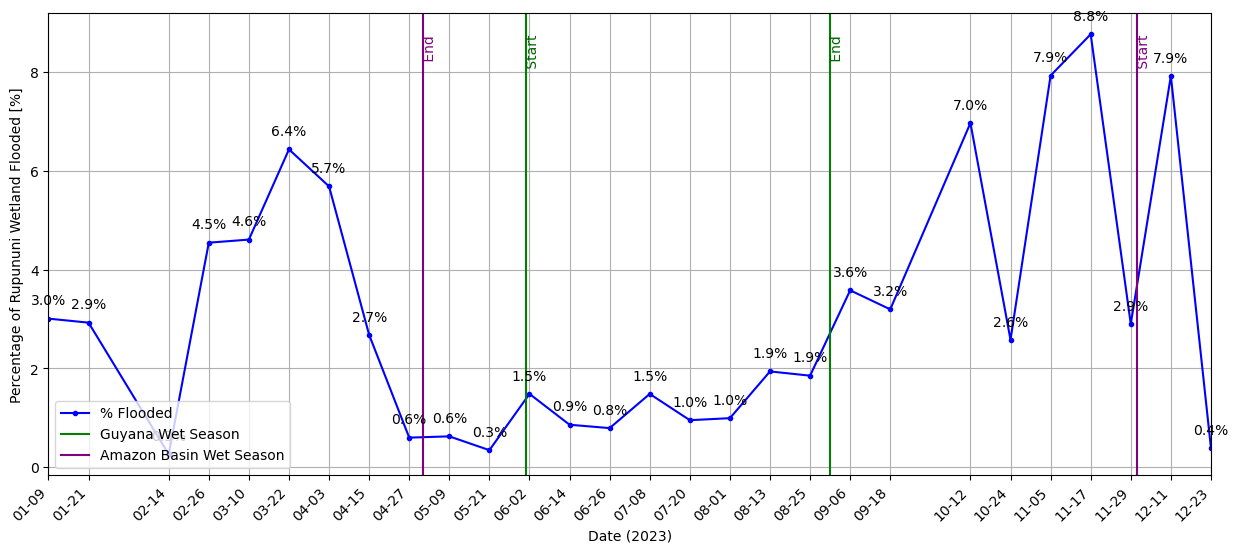

In [11]:
### PRINT PLOT FOR COMBINED WATER MASKS

# Use previous code to calculate total number of pixels in AOI. 
# Store total number of pixels in AOI below
# total_pixels = 28784773 #100% wetland
total_pixels = 27312276 # 94.9% wetland

%matplotlib inline

def extract_date_from_filename(filename):
    base = os.path.basename(filename)
    date_part = base.split('_')[3:6]
    date_str = '_'.join(date_part)
    return datetime.strptime(date_str, '%Y_%m_%d')

def count_flooded_pixels(file_path):
    with rasterio.open(file_path) as src:
        flood_mask = src.read(1)
        flooded_pixels = (flood_mask == 1).sum()
        return flooded_pixels

# Directory paths
water_masks_directory = "/home/jovyan/GuyanaFlooding/data/Water_Masks"

flood_percentages = []
dates = []
years = set()

# Iterate over each file in the water masks directory
for filename in sorted(os.listdir(water_masks_directory)):
    if filename.endswith("_combined.tif"):
        water_mask_path = os.path.join(water_masks_directory, filename)
        date = extract_date_from_filename(filename)
        
        try:
            flooded_pixels = count_flooded_pixels(water_mask_path)
            flood_percentage = (
                flooded_pixels / total_pixels) * 100 if total_pixels > 0 else 0
            flood_percentages.append(flood_percentage)
            dates.append(date)
            years.add(date.year)
        except Exception as e:
            print(f"Failed to process {filename}: {e}")

# Create a DataFrame for plotting
if dates and flood_percentages:
    df = pd.DataFrame({
        'Date': pd.to_datetime(dates),
        'Flood Percentage': flood_percentages
    })
    df = df.sort_values('Date')

    # Set the plot limits to the first and last dates
    first_date = df['Date'].min()
    last_date = df['Date'].max()

    fig = plt.figure(figsize=(15, 6))
    ax = fig.add_subplot(111)
    ax.plot(np.array(df['Date']),
            np.array(df['Flood Percentage']),
            color='b', 
            marker='o',
            markersize=3, 
            label='% Flooded')

    # Vertical lines and labels
    #Guyana wet season
    Gstart_season = datetime(first_date.year, 6, 1)
    Gend_season = datetime(first_date.year, 8, 31)
    ax.axvline(x=Gstart_season, color='green', label='Guyana Wet Season')
    ax.axvline(x=Gend_season, color='green')

    ax.text(Gstart_season, max(df['Flood Percentage']), ' Start', 
            rotation=90, verticalalignment='top', color='darkgreen')
    ax.text(Gend_season, max(df['Flood Percentage']), ' End', 
            rotation=90, verticalalignment='top', color='darkgreen')

    #Amazon wet season
    Astart_season = datetime(first_date.year, 12, 1)
    Aend_season = datetime(first_date.year, 5, 1)
    ax.axvline(x=Astart_season, color='purple', label='Amazon Basin Wet Season')
    ax.axvline(x=Aend_season, color='purple')

    ax.text(Astart_season, max(df['Flood Percentage']), ' Start',
            rotation=90, verticalalignment='top', color='purple')
    ax.text(Aend_season, max(df['Flood Percentage']), ' End', 
            rotation=90, verticalalignment='top', color='purple')

    
    
    # Set x-axis to show each date
    ax.set_xlim([first_date, last_date])
    ax.set_xticks(df['Date'])
    ax.set_xticklabels([date.strftime('%m-%d') for date in df['Date']],
                       rotation=45, ha='right')

    # Annotate each point with its percentage
    for i, txt in enumerate(df['Flood Percentage']):
        ax.annotate(f"{txt:.1f}%", (mdates.date2num(df['Date'][i]),
                                    df['Flood Percentage'][i]),
                                    textcoords="offset points", 
                                    xytext=(0,10), ha='center')
    
    year_str = ', '.join(sorted(map(str, years)))
    ax.set_xlabel(f'Date ({year_str})')
    ax.set_ylabel('Percentage of Rupununi Wetland Flooded [%]')
    ax.grid(True)
    ax.legend(loc='lower left')

    # Ensure the directory exists and save the plot
    output_dir = "/home/jovyan/GuyanaFlooding/outputs"
    #Create directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True) 
    save_path = os.path.join(output_dir,
                             f'FloodPercentageTimeSeries {year_str}.png')
    plt.savefig(save_path, dpi=300, transparent=True)
    plt.show()
else:
    print("No data to plot.")


#### OPTIONAL: SET UP TO DISPLAY WATER MASK WITH SAR IMAGE & DISPLAY ALL IMAGES IN THE TIME SERIES

<font face="Calibri" size="3"><b>The following code cells allow you to visualize individual flood maps superimposed on the respective SAR image they were derived from.</b>

This next code cell first creates the information we are plotting below such as surface water and SAR data stacks.
</font>

In [ ]:
#### OPTIONAL: SET UP TO DISPLAY WATER MASK WITH SAR IMAGE

def display_sar_with_mask(sar_path, mask_path, date):
    # Open the SAR image
    with rasterio.open(sar_path) as sar_src:
        sar_image = sar_src.read(1)  # Read the first band
        vmin = np.percentile(sar_image, 5)  # Calculate 5th percentile for vmin
        vmax = np.percentile(sar_image, 95)  # Calculate 95th percentile for vmax

    # Open the water mask image
    with rasterio.open(mask_path) as mask_src:
        mask_image = mask_src.read(1)  # Read the first band
        water_masked = np.ma.masked_where(mask_image == 0, mask_image)  # Mask non-water pixels

    # Create a colormap with one color (blue) for flooded areas
    flood_cmap = ListedColormap(['none', 'blue'])

    # Plotting the SAR image and the water mask overlay
    plt.figure(figsize=(9, 6))
    plt.imshow(sar_image, cmap='gray', vmin=vmin, vmax=vmax, interpolation='none')
    water_display = plt.imshow(water_masked, cmap=flood_cmap, interpolation='none')  # Apply the custom colormap

    # Add a color bar with a specific label
    cbar = plt.colorbar(water_display, ticks=[1], shrink=0.5)

    # Position the color bar below the plot
    plt.subplots_adjust(bottom=0.15)

    plt.title(f'Water Mask on SAR Image: {date.strftime("%Y-%m-%d")}')
    plt.grid(False)
    plt.show()

# Show date index 
# Optional: Print the mapping
for idx, info in image_info.items():
    print(f"Index {idx}: Date {info['date'].strftime('%Y-%m-%d')}")

# Call function and choose image to display
image_index = 7  # For example, using image index 7
if image_index in image_info:
    info = image_info[image_index]
    display_sar_with_mask(info['rtc_vv_path'], info['water_mask_path'], info['date'])
else:
    print("No image information available for the specified index.")


In [ ]:
#### OPTIONAL: DISPLAY ALL IMAGES IN THE TIME SERIES

# Loop through each image index and display the SAR image with mask
for image_index, info in image_info.items():
    print(f"Displaying SAR image with mask for index {image_index}")
    display_sar_with_mask(info['rtc_vv_path'], info['water_mask_path'], info['date'])


## Create Summary Statistics

<font face="Calibri" size="4"> The following code is from the original notebook. It was not adapted since it was not needed. The cells need to be edited to work with this current version of the notebook</font>

<font face="Calibri" size="3">Once flood maps for each individual image acquisition date were created, summary statistics can be derived that describe the severity and duration of an event. In the following, <b>we will be deriving a metric describing how many days each image pixel was inundated during an analyzed event</b>. This should provide a template for other metrics to be created.</font>

#### OPTIONAL: FROM OG NOTEBOOK, NEEDS FIX

In [2]:
#### OPTIONAL: FROM OG NOTEBOOK, NEEDS FIX
rasterstack = wm.ReadAsArray()
srs = np.shape(rasterstack)
floodcount = np.sum(rasterstack,0)
floodpercent = floodcount / srs[0] * 100
dt = time_index.dayofyear[SARbands] - time_index.dayofyear[0]
flooddays = floodpercent / 100 * dt
rasterstack = 0
fd_masked = np.ma.masked_where(flooddays==0, flooddays)

SARraster = img.GetRasterBand(SARbands).ReadAsArray()
plt.figure(figsize=(9, 6))
vmin = np.percentile(SARraster, 5)  #vh_array
vmax = np.percentile(SARraster, 95)
plt.suptitle('Number of Inundated Days Per Pixel - Minimum SAR Image as Background')
plt.imshow(SARraster, cmap='gray', vmin=vmin, vmax=vmax)
im = plt.imshow(fd_masked, cmap='jet')
plt.colorbar(im, orientation='vertical')
plt.grid()
outfile = f"{mask_directory}/flooddays.tif"
write_mask_to_file(flooddays, outfile, img.GetProjection(), img.GetGeoTransform())


NameError: name 'wm' is not defined

# Version Log

<font face="Calibri" size="2" color="gray"> <i> Adapted from SARHazards_Lab_Floods.ipynb - Version 1.0.4 - 11/03/2021 on4/27/2024 by André de Oliveira.

- Last edited 4/27/2024 by André

Recent Changes:
- Cleaned up notebook
</i></font>